In [8]:
import pandas as pd
import numpy as np

In [3]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',index_col=0, parse_dates=True).dropna()
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [5]:
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data.head()

,price
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


In [12]:

lags = 5

# Update the data frame with the lags columns
lag_cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    
    # Takes the price column and shifts it by lag.
    data[col] = data['price'].shift(lag)
    
    lag_cols.append(col)
data.dropna(inplace=True)
data.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-19,1.4298,1.4382,1.4502,1.4510,1.4494,1.4513
2010-01-20,1.4101,1.4298,1.4382,1.4502,1.4510,1.4494
2010-01-21,1.4090,1.4101,1.4298,1.4382,1.4502,1.4510
2010-01-22,1.4137,1.4090,1.4101,1.4298,1.4382,1.4502
2010-01-25,1.4150,1.4137,1.4090,1.4101,1.4298,1.4382


In [9]:
# Perform a Least Square Regression
reg = np.linalg.lstsq(data[lag_cols], data['price'],rcond=None)[0]
reg

array([ 0.98635864,  0.02292172, -0.04769849,  0.05037365, -0.01208135])

The optimal regression parameters illustrate what is typically called the random walk hypothesis. This hypothesis states that stock prices or exchange rates, for example, follow a random walk with the consequence that the best predictor for tomorrow’s price is today’s price. The optimal parameters seem to support such a hypothesis since today’s price almost completely explains the predicted price level for tomorrow. The four other values hardly have any weight assigned.

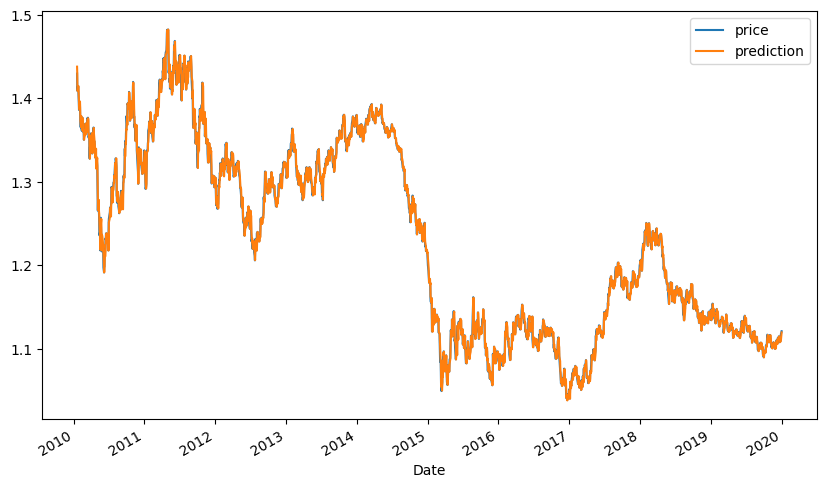

In [13]:
# Calculates the prediction values as the dot product.
data['prediction'] = np.dot(data[lag_cols], reg)

# Plots the price and prediction columns.
data[['price', 'prediction']].plot(figsize=(10, 6));

The figure shows the EUR/USD exchange rate and the predicted values. Due to the sheer amount of data for the multi-year time window, the two time series are indistinguishable in the plot:

Zooming in by plotting the results for a much shorter time window allows one to better distinguish the two time series. Figure 5-4 shows the results for a three months time window. This plot illustrates that the prediction for tomorrow’s rate is roughly today’s rate. The prediction is more or less a shift of the original rate to the right by one trading day:

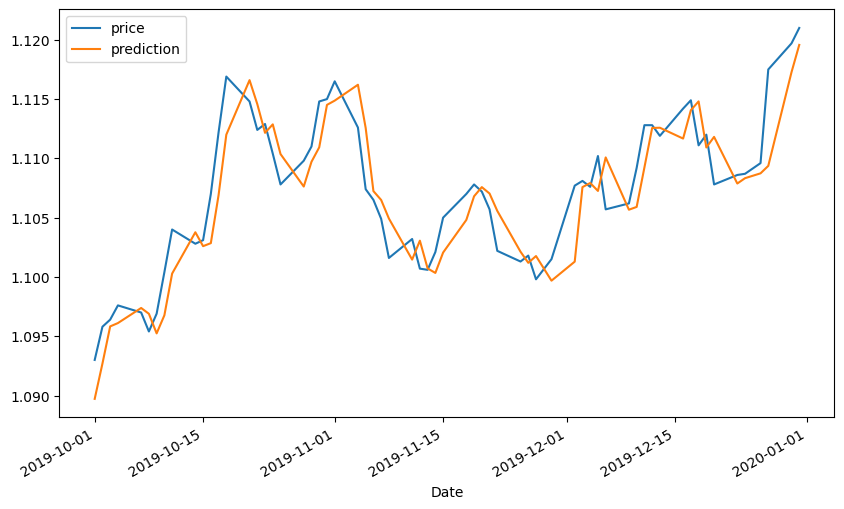

In [14]:
data[['price', 'prediction']].loc['2019-10-1':].plot(figsize=(10, 6));

## Log returns

So far, the analysis is based on absolute rate levels. However, **(log) returns might be a better choice for such statistical applications due to, for example, their characteristic of making the time series data stationary**. The code to apply linear regression to the returns data is almost the same as before. This time it is not only today’s return that is relevant to predict tomorrow’s return, but the regression results are also completely different in nature:

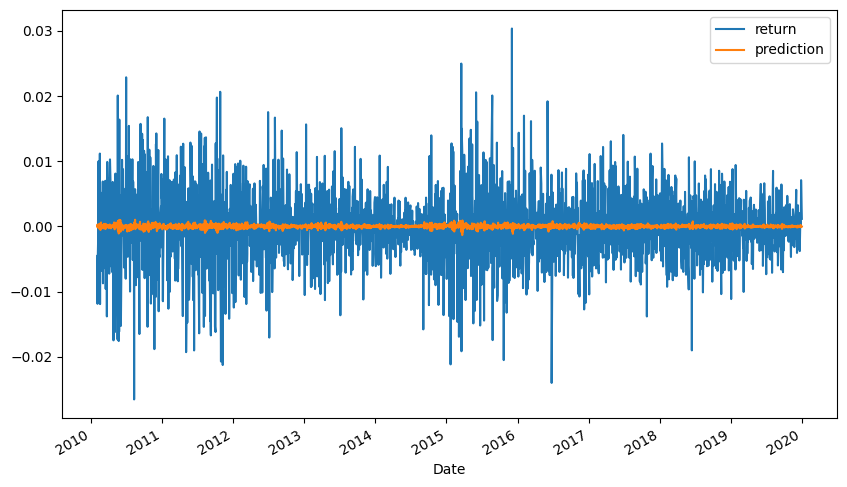

In [15]:
# Calculates the log returns.
data['return'] = np.log(data['price'] /data['price'].shift(1))

# Deletes all lines with NaN values.
data.dropna(inplace=True)

# Update the data frame with the lags columns
lag_cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    lag_cols.append(col)
data.dropna(inplace=True)

reg = np.linalg.lstsq(data[lag_cols], data['return'],rcond=None)[0]

data['prediction'] = np.dot(data[lag_cols], reg)

data[['return', 'prediction']].iloc[lags:].plot(figsize=(10, 6));

Figure 5-5 shows the returns data and the prediction values. As the figure impressively illustrates, **linear regression obviously cannot predict the magnitude of future returns to some significant extent**:


From a trading point of view, one might argue that it is not the magnitude of the fore 
casted return that is relevant, but rather whether the direction is forecasted correctly
or not. To this end, a simple calculation yields an overview. Whenever the linear
regression gets the direction right, meaning that the sign of the forecasted return is
correct, the product of the market return and the predicted return is positive and
otherwise negative.

In the example case, the prediction is 1,250 times correct and 1,242 wrong, which
translates into a hit ratio of about 49.9%, or almost exactly 50%:

In [16]:
# Calculates the product of the market and predicted return, takes the sign of the results and counts the values.
hits = np.sign(data['return'] * data['prediction']).value_counts()
hits


 1.0    1245
-1.0    1242
 0.0      13
Name: count, dtype: int64

In [17]:
hits.values[0] / sum(hits)

np.float64(0.498)

## Predicting Future Market Direction

The question that arises is whether one can improve on the hit ratio by directly implementing the linear regression based on the sign of the log returns that serve as the dependent variable values. In theory at least, this simplifies the problem from predicting an absolute return value to the sign of the return value. The only change in the Python code to implement this reasoning is to use the sign values (that is, 1.0 or -1.0 in Python) for the regression step. This indeed increases the number of hits to 1,301 and the hit ratio to about 51.9%—an improvement of two percentage points:

In [18]:
reg = np.linalg.lstsq(data[lag_cols], np.sign(data['return']),rcond=None)[0]
data['prediction'] = np.sign(np.dot(data[lag_cols], reg))
data['prediction'].value_counts()
hits = np.sign(data['return'] *data['prediction']).value_counts()
hits

 1.0    1295
-1.0    1192
 0.0      13
Name: count, dtype: int64

In [19]:
hits.values[0] / sum(hits)

np.float64(0.518)

## Vectorized Backtesting of Regression-Based Strategy

The hit ratio alone does not tell too much about the economic potential of a trading strategy using linear regression in the way presented so far. It is well known that the ten best and worst days in the markets for a given period of time considerably influence the overall performance of investments.2 In an ideal world, a long-short trader would try, of course, to benefit from both best and worst days by going long and short, respectively, on the basis of appropriate market timing indicators. Translated to the current context, this implies that, in addition to the hit ratio, the quality of the market timing matters. Therefore, a backtesting along the lines of the approach in Chapter 4 can give a better picture of the value of regression for prediction.

Given the data that is already available, vectorized backtesting boils down to two lines of Python code including visualization. This is due to the fact that the prediction values already reflect the market positions (long or short). Figure 5-6 shows that, insample, the strategy under the current assumptions outperforms the market significantly (ignoring, among other things, transaction costs):

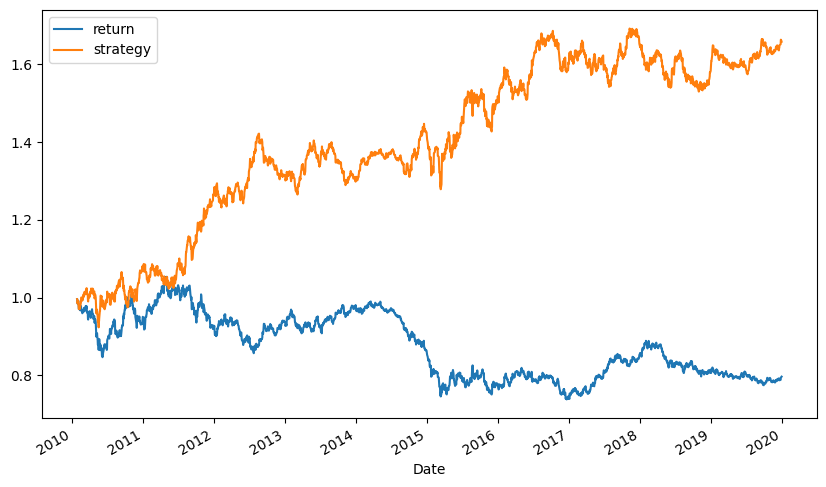

In [20]:
data['strategy'] = data['prediction'] * data['return']
data[['return', 'strategy']].sum().apply(np.exp)
data[['return', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

The hit ratio of a prediction-based strategy is only one side of the coin when it comes to overall strategy performance. The other side is how well the strategy gets the market timing right. A strategy correctly predicting the best and worst days over a certain period of time might outperform the market even with a hit ratio below 50%. On the other hand, a strategy with a hit ratio well above 50% might still underperform the base instrument if it gets the rare, large movements wrong.

## Generalizing the Approach

In [21]:
import linear_reg_backtester as LR

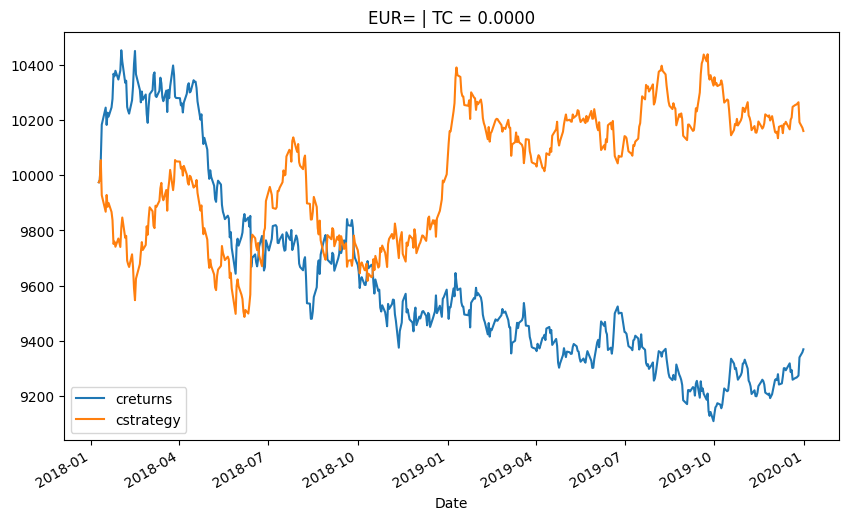

In [22]:
lrbt = LR.LRVectorBacktester('EUR=', '2010-1-1', '2019-12-31',10000, 0.0)
lrbt.run_strategy('2010-1-1', '2019-12-31','2010-1-1', '2019-12-31', lags=5)
lrbt.run_strategy('2010-1-1', '2017-12-31','2018-1-1', '2019-12-31', lags=5)
lrbt.plot_results()

Gross performance of EUR/USD and the regression-based strategy (five lags,out-of-sample, before transaction costs)

Consider the GDX ETF. The strategy configuration chosen shows an outperformance out-of-sample and after taking transaction costs into account (see Figure 5-8):

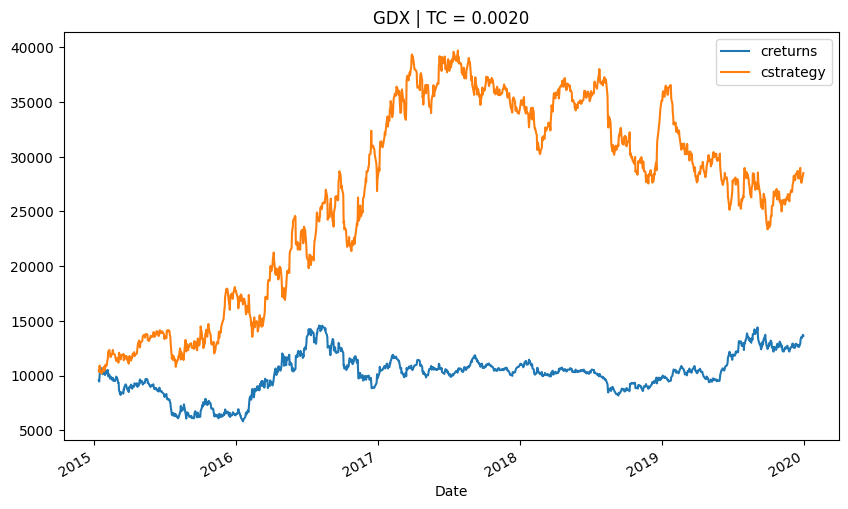

In [23]:
lrbt = LR.LRVectorBacktester('GDX', '2010-1-1', '2019-12-31',10000, 0.002)
lrbt.run_strategy('2010-1-1', '2019-12-31','2010-1-1', '2019-12-31', lags=7)
lrbt.run_strategy('2010-1-1', '2014-12-31','2015-1-1', '2019-12-31', lags=7)
lrbt.plot_results()


Gross performance of the GDX ETF and the regression-based strategy (seven lags, out-of-sample, after transaction costs)